# DETR - Detection Transformer
Reference: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb


Original DETR paper: https://arxiv.org/abs/2005.12872

Original DETR repo: https://github.com/facebookresearch/detr


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python --version

Python 3.10.12


In [3]:
!python -m pip install --upgrade pip

!pip install supervision==0.3.0

!pip install transformers

!pip install pytorch-lightning

!pip install timm

!pip install cython

!pip install pycocotools

!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 43.3 MB/s eta 0:00:00


In [ ]:
!pip --version

pip 24.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
import torch
torch.__version__

'2.4.1+cu121'

In [ ]:
import supervision
import transformers

supervision.__version__ , transformers.__version__

('0.3.0', '4.44.2')

In [ ]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.4.0


## Create COCO data loaders

### About dataset:

#### number of classes - 4  ['angle', 'fracture', 'line', 'messed_up_angle'


![image.png](attachment:3c3cf0f7-faa8-477c-b8df-40ff4415b187.png)]

![image.png](attachment:d4d14b07-49fc-4d16-b0c0-702e6620cd17.png)

In [ ]:
#!unzip /content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/bone_fracture_coco.zip -d /content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/dataset

In [ ]:
from transformers import DetrImageProcessor

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
import torchvision

dataset = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/dataset'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

# Define the image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #213


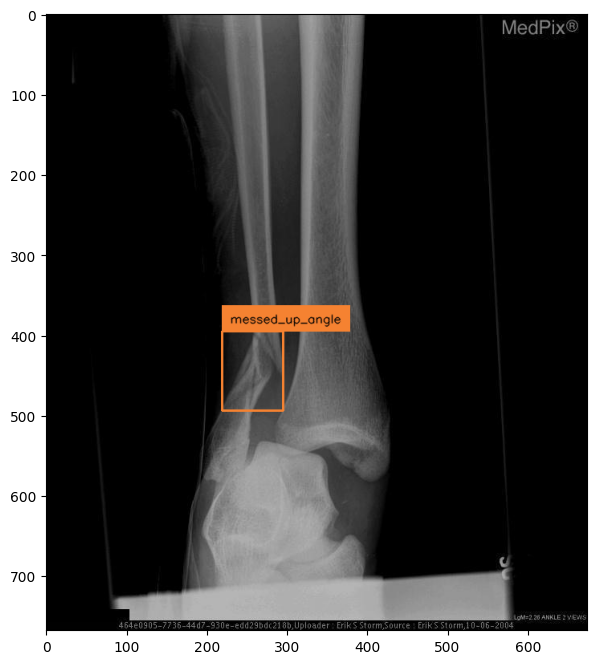

In [ ]:
import os
import random
import cv2
import numpy as np
import supervision as sv

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotations
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (8, 8))


Image #20


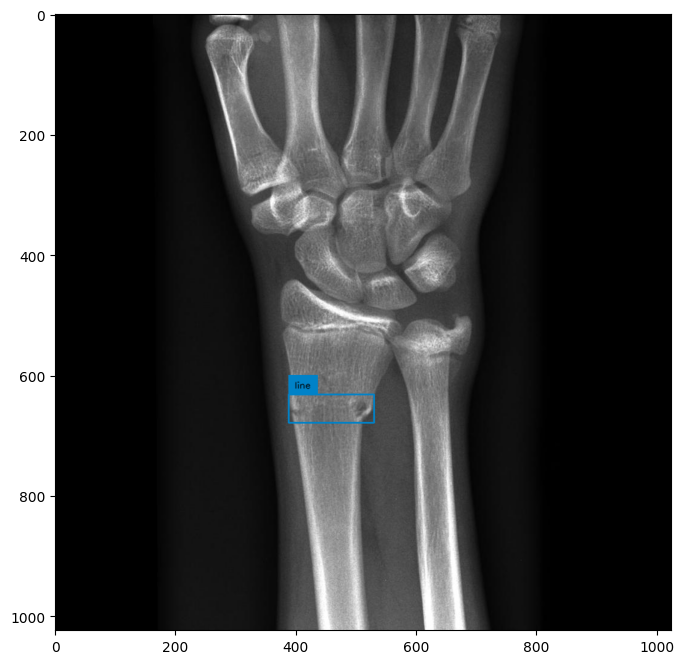

In [ ]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

# Define the model checkpoint and id2label
CHECKPOINT = "facebook/detr-resnet-50"  # Change to your desired checkpoint

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 200

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


# Save and load model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model'
model.model.save_pretrained(MODEL_PATH)

NameError: name 'model' is not defined

In [ ]:

MODEL_PATH = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model'
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

Image #33


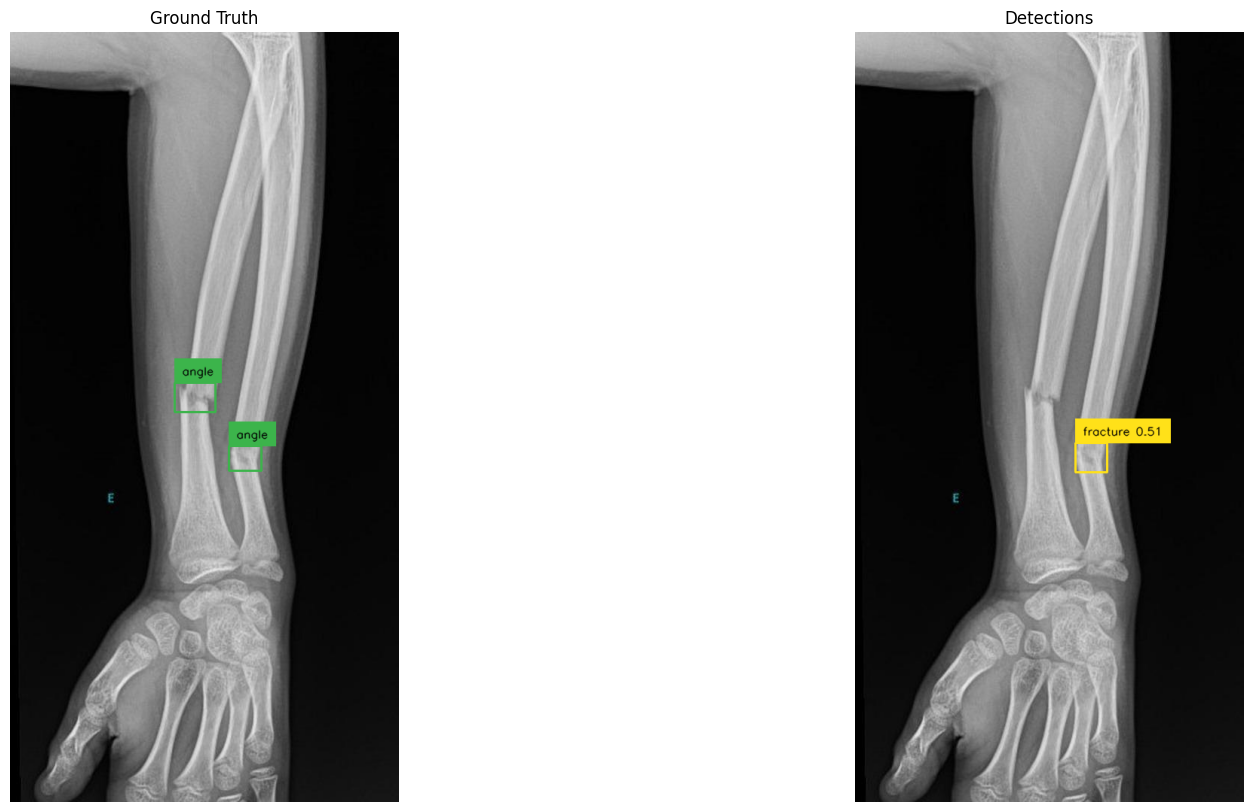

In [ ]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
CONFIDENCE_TRESHOLD = 0.5
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)




# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()


In [ ]:
print('working')

working


#### model exporting

In [ ]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 123.2 MB/s eta 0:00:00


In [ ]:
!pip install openvino


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary


summary(model, input_size=(1, 3, 800, 800))

Layer (type:depth-idx)                                                 Output Shape              Param #
DetrForObjectDetection                                                 [1, 625, 256]             --
├─DetrModel: 1-1                                                       [1, 625, 256]             25,600
│    └─DetrConvModel: 2-1                                              [1, 256, 200, 200]        --
│    │    └─DetrConvEncoder: 3-1                                       [1, 256, 200, 200]        23,454,912
│    │    └─DetrSinePositionEmbedding: 3-2                             [1, 256, 200, 200]        --
│    │    └─DetrSinePositionEmbedding: 3-3                             [1, 256, 100, 100]        --
│    │    └─DetrSinePositionEmbedding: 3-4                             [1, 256, 50, 50]          --
│    │    └─DetrSinePositionEmbedding: 3-5                             [1, 256, 25, 25]          --
│    └─Conv2d: 2-2                                                     [1, 256, 25,

In [ ]:
import torch

# Assuming your model is already defined and loaded
model = model.to('cuda')  # Move model to GPU

# Create dummy input for the model
dummy_input = torch.randn(1, 3, 800, 800).to('cuda')  # Move dummy input to GPU

# Call the export function
torch.onnx.export(model, dummy_input, '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/onnx/model.onnx')


/usr/local/lib/python3.10/dist-packages/transformers/models/detr/modeling_detr.py:582: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (batch_size * self.num_heads, target_len, source_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/detr/modeling_detr.py:589: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attention_mask.size() != (batch_size, 1, target_len, source_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/detr/modeling_detr.py:613: TracerWarning: Converting a tensor to a Python boolean 

In [ ]:
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openvino.runtime import Core
import supervision as sv  # Assuming this library provides the BoxAnnotator and Detections classes

CONFIDENCE_THRESHOLD = 0.5

# Setup categories and ID to label mapping
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}
box_annotator = sv.BoxAnnotator()

# Select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# Load image and annotations
image_info = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Initialize OpenVINO runtime and load the model
ie = Core()
model_path = "/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/openvino/model.xml"
compiled_model = ie.compile_model(model=model_path, device_name="CPU")

# Get input and output layers
input_layer = compiled_model.inputs[0]
output_layer = compiled_model.outputs[0]

# Preprocess the image for OpenVINO
def preprocess_image(image, target_size=(800, 800)):
    original_shape = image.shape[:2]
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_rgb = image_normalized[..., ::-1]
    image_transposed = np.transpose(image_rgb, (2, 0, 1))
    image_expanded = np.expand_dims(image_transposed, axis=0)
    return image_expanded, original_shape

# Postprocess the results
def postprocess_results(results, original_shape, threshold=CONFIDENCE_THRESHOLD):
    boxes = results[0][:, :4]
    scores = results[0][:, 4]
    class_ids = results[0][:, 5].astype(int)
    keep_indices = scores > threshold

    # Scale the boxes back to the original image size
    h, w = original_shape
    boxes[:, [0, 2]] *= w
    boxes[:, [1, 3]] *= h

    # Filter out boxes below the threshold
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    class_ids = class_ids[keep_indices]
    return boxes, scores, class_ids

# Inference function
def run_inference(image):
    # Preprocess the input image
    input_image, original_shape = preprocess_image(image)

    # Perform inference
    results = compiled_model([input_image])[output_layer]

    # Postprocess results
    boxes, scores, class_ids = postprocess_results(results, original_shape)

    # Create detections
    detections = sv.Detections.from_numpy(boxes=boxes, scores=scores, class_ids=class_ids)
    return detections

# Run inference and annotate detections
detections = run_inference(image)
labels = [f"{id2label[class_id]} {confidence:.2f}" for confidence, class_id in zip(detections.scores, detections.class_ids)]
frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()


Image #32


AttributeError: type object 'Detections' has no attribute 'from_numpy'

In [ ]:
import cv2
import numpy as np
from openvino.inference_engine import IECore

# Load the OpenVINO model
model_xml = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/openvino/model.xml'
model_bin = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/openvino/model.bin'

# Initialize the inference engine
ie = IECore()

# Read the network and weights
net = ie.read_network(model=model_xml, weights=model_bin)

# Load the model on the specified device (e.g., CPU or GPU)
exec_net = ie.load_network(network=net, device_name='CPU')

# Prepare input blob
input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

# Read and preprocess the input image
image_path = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/dataset/train/101_jpg.rf.01df1023e27cc86113edc3d17e5d9849.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (800, 800))  # Resize to model's input size
image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
image = image[np.newaxis, :]  # Add batch dimension

# Perform inference
results = exec_net.infer(inputs={input_blob: image})

# Process output
output = results[output_blob]

# Process and visualize results (depends on your model's output)
# Example for object detection
for detection in output[0][0]:
    confidence = detection[2]  # Confidence score
    if confidence > 0.5:  # Threshold
        xmin, ymin, xmax, ymax = map(int, detection[:4])  # Bounding box coordinates
        cv2.rectangle(image[0].transpose((1, 2, 0)), (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image[0].transpose((1, 2, 0)), f'{confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the output image
cv2.imshow('Detections', image[0].transpose((1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'openvino.inference_engine'

In [ ]:
import numpy as np
import cv2
from openvino.runtime import Core, Tensor

# Load the OpenVINO model
model_xml = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/openvino/model.xml'
model_bin = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/output_model/openvino/model.bin'

# Initialize OpenVINO runtime
core = Core()

# Read the model
model = core.read_model(model=model_xml, weights=model_bin)

# Compile the model for a specific device (e.g., CPU)
compiled_model = core.compile_model(model=model, device_name='GPU')

# Prepare input and output
input_layer = compiled_model.input(0)  # Get the first input layer
output_layer = compiled_model.output(0)  # Get the first output layer

# Read and preprocess the input image
image_path = '/content/drive/MyDrive/POC/DETR_POC/pytorch_DETR/dataset/train/101_jpg.rf.01df1023e27cc86113edc3d17e5d9849.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (800, 800))  # Resize to model's input size
image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
image = image[np.newaxis, :].astype(np.float32)  # Add batch dimension and ensure type is float32

# Create an inference request
infer_request = compiled_model.create_infer_request()

# Create an OpenVINO tensor from the NumPy array
input_tensor = Tensor(image)

# Set the input tensor
infer_request.set_input_tensor(input_tensor)

# Perform inference
infer_request.infer()

# Get the output tensor
output_tensor = infer_request.get_output_tensor(output_layer)

# Process and visualize results (depends on your model's output)
# Example for object detection
output = output_tensor.data

for detection in output[0][0]:
    confidence = detection[2]  # Confidence score
    if confidence > 0.5:  # Threshold
        xmin, ymin, xmax, ymax = map(int, detection[:4])  # Bounding box coordinates
        cv2.rectangle(image[0].transpose((1, 2, 0)), (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image[0].transpose((1, 2, 0)), f'{confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the output image
cv2.imshow('Detections', image[0].transpose((1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()


RuntimeError: Exception from src/inference/src/cpp/core.cpp:104:
Check '!m_device_map.empty()' failed at src/plugins/intel_gpu/src/plugin/plugin.cpp:383:
[GPU] Can't get PERFORMANCE_HINT property as no supported devices found or an error happened during devices query.
[GPU] Please check OpenVINO documentation for GPU drivers setup guide.




In [ ]:
import numpy as np
import cv2
from openvino.runtime import Core

# Load the OpenVINO model


# Initialize OpenVINO runtime
core = Core()

# Read the model
model = core.read_model(model=model_xml, weights=model_bin)

# Compile the model for a specific device (e.g., CPU, GPU)
compiled_model = core.compile_model(model=model, device_name='CPU')

# Prepare input and output
input_layer = compiled_model.input(0)  # Get the first input layer
output_layer = compiled_model.output(0)  # Get the first output layer


image = cv2.imread(image_path)
image = cv2.resize(image, (800, 800))  # Resize to model's input size
image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
image = image[np.newaxis, :].astype(np.float32)  # Add batch dimension and ensure type is float32

# Create an inference request
infer_request = compiled_model.create_infer_request()

# Set the input tensor
input_tensor = core.create_tensor(image)  # Use the Core to create the tensor
infer_request.set_input_tensor(input_tensor)

# Perform inference
infer_request.infer()

# Get the output tensor
output_tensor = infer_request.get_output_tensor(output_layer)

# Process and visualize results (depends on your model's output)
# Example for object detection
output = output_tensor.data

for detection in output[0][0]:
    confidence = detection[2]  # Confidence score
    if confidence > 0.5:  # Threshold
        xmin, ymin, xmax, ymax = map(int, detection[:4])  # Bounding box coordinates
        cv2.rectangle(image[0].transpose((1, 2, 0)), (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image[0].transpose((1, 2, 0)), f'{confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the output image
cv2.imshow('Detections', image[0].transpose((1, 2, 0)))
cv2.waitKey(0)
cv2.destroyAllWindows()


AttributeError: 'Core' object has no attribute 'create_tensor'